## Creating a graph from text data
Looking at the neighbours of a selected word

### Loading the text data

In [1]:
import pandas as pd
import itertools

In [2]:
graph_data_path = '/home/benjamin/Documents/memetracker/Data/graph/'
pickle_data_path = '/home/benjamin/Documents/memetracker/Data/pickle/'
series_name = 'marseille'
pickle_file = pickle_data_path+series_name+'_texts'+'.pkl'
vocab_file = pickle_data_path+series_name+'_vocab_bow'+'.pkl'
tfidf_file = pickle_data_path+series_name+'_vocab_tfidf'+'.pkl'

In [3]:
text_data = pd.read_pickle(pickle_file)
vocab_data = pd.read_pickle(vocab_file)
tfidf_data = pd.read_pickle(tfidf_file)

In [4]:
# create the set of most used words
#nb_words = 200
#word_set = set(tfidf_data.words[0:nb_words])

###  Selecting documents with particular keywords

In [5]:
# find the words that follow the keyword candidat_word
candidat_word = "Liberté"
selected_Keywords = set(candidat_word.split())
data_subset = []
neighbour_list = []
for text in text_data.filtered_text:
    wordlist = str(text).split()
    if len(set(wordlist)&selected_Keywords)>=(len(selected_Keywords)):
        data_subset.append(text)
        word_ind = wordlist.index(candidat_word)
        if (word_ind+1<len(wordlist)):
            neighbour_list.append(wordlist[word_ind+1])

In [6]:
from collections import Counter

In [7]:
N_uniquedic = Counter(neighbour_list)
N_words = {k:v for (k,v) in N_uniquedic.items() if v > 0}
Ndf = pd.DataFrame(list(N_words.items()), columns=['word','nb_occur'])
Ndf = Ndf.sort_values('nb_occur',ascending=False)
Ndf = Ndf.reset_index(drop=True)

In [8]:
Ndf

,word,nb_occur
0,Égalité,848
1,égalité,53
2,Egalité,30
3,Vitrolles,5
4,Responsabilité,4
5,CGLPL,2
6,écris,1
7,pluralité,1
8,scénario,1
9,janvier,1


## Computing the hirarchical structure 

In [9]:
def find_neighbours(word,texts,direction='forward'):
    # find the words that follow (direction='forward') or precede (direction='backward')
    # the keyword 'word' in the texts 'texts'
    # return 
    # * the list of keywords with their occurence in a pandas dataframe
    # * the list of texts where the word has been found
    # Example:
    #         word_list,texts_list = find_neighbours(word,texts,direction='forward')
    neighbour_list = []
    texts_subset = []
    #print(word)
    for text in texts:
        text = text.lower()
        wordlist = str(text).split()
        if len(set(wordlist)&set([word]))>0:
            word_ind = wordlist.index(word)
            texts_subset.append(text)
            if direction=='forward':
                if (word_ind+1<len(wordlist)):
                    neighbour_list.append(wordlist[word_ind+1])
            elif direction=='backward':
                if (word_ind-1>0):
                    neighbour_list.append(wordlist[word_ind-1])
            else :
                raise NameError('Unknown direction')
    N_uniquedic = Counter(neighbour_list)
    # optionally: filter te dic for removing the lowest values
    N_words = {k:v for (k,v) in N_uniquedic.items() if v > 0}
    Ndf = pd.DataFrame(list(N_words.items()), columns=['word','nb_occur'])
    Ndf = Ndf.sort_values('nb_occur',ascending=False)
    Ndf = Ndf.reset_index(drop=True)
    return Ndf,texts_subset

In [10]:
def top_neighbours(word,texts,top_n=10):
    Ndf,texts_subset = find_neighbours(word,texts,direction='forward')
    return Ndf.head(top_n)

In [11]:
def graph_neighbours(G,parent,word,neighbour_data,layer_id):
    parent_node = word+parent+str(layer_id-1)
    total_occur = neighbour_data.nb_occur.sum()
    for idx,node_row in neighbour_data.iterrows():
        G.add_node(node_row.word+word+str(layer_id),name=node_row.word, occur=node_row.nb_occur)
        G.add_edge(parent_node,node_row.word+word+str(layer_id),weight=node_row.nb_occur*1.0/total_occur)
    return parent_node

In [12]:
def expand_neighbours(parent,word,texts,layer_id,layer_max=4,top_n=10):
    if layer_id >= layer_max:
        return []
    neighbour_data = top_neighbours(word,texts,top_n)
    graph_neighbours(G,parent,word,neighbour_data,layer_id)
    layer_id+=1
    parent_node = word
    neighbour_list = list(neighbour_data.word)
    for nnode in neighbour_list:
        expand_neighbours(parent_node,nnode,texts,layer_id,layer_max,top_n)

### Creating the graph

In [13]:
import networkx as nx
import matplotlib.pyplot as plt

In [28]:
G = nx.DiGraph()
# root word
candidat_word = "miss"
layer_id=0
parent = ''
candidat_id = candidat_word+parent+str(layer_id)
# compute the number of occurences of the word:
word_list,texts_list = find_neighbours(candidat_word,text_data.filtered_text,direction='forward')
nb_occur = len(texts_list)
G.add_node(candidat_id,name=candidat_word, occur=nb_occur)
# find children nodes
expand_neighbours(parent,candidat_word,texts=text_data.filtered_text,layer_id=1,layer_max=3,top_n=15)
#parent,level1 = expand_neighbours(parent,[candidat_word],text_data.filtered_text,top_n=10,layer_id=1)
#parent,level2 = expand_neighbours(parent,level1,text_data.filtered_text,top_n=2,layer_id=2)
#level3 = expand_neighbours(level2,text_data.filtered_text,top_n=10)
#level4 = expand_neighbours(level3,text_data.filtered_text,top_n=10)

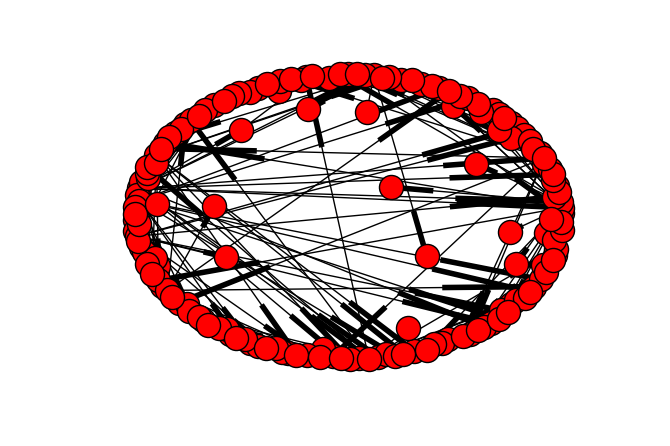

In [29]:
nx.draw_spring(G,)
plt.show()

In [30]:
G.size()

159

### Thresholding the edges

In [31]:
# Extracting the edge information
#sum_weight = 0
#n_edges = 0
#for u,v,a in G.edges(data=True):
#    sum_weight+=a['weight']
#    n_edges+=1
#average_weight = sum_weight*1.0/n_edges

In [32]:
# Node properties: degree and centrality
degreeDic = G.degree(weight='weight')
nx.set_node_attributes(G,'degree',degreeDic)
bcDic = nx.betweenness_centrality(G)
nx.set_node_attributes(G,'bCentrality',bcDic)

In [33]:
# Write the graph to a json file
from networkx.readwrite import json_graph
datag = json_graph.tree_data(G,root=candidat_id)
import json
s = json.dumps(datag)
#datag['links'] = [
#        {
#            'source': datag['nodes'][link['source']]['id'],
#            'target': datag['nodes'][link['target']]['id']
#        }
#        for link in datag['links']]
s = json.dumps(datag)
with open("viz/treegraph"+series_name+".json", "w") as f:
    f.write(s)

### Open a web page for visualization

In [34]:
# Open a webserver :
# python3 -m http.server 8008 --bind 127.0.0.1

In [35]:
import webbrowser
url = 'http://localhost:8008/treegraphmarseille.html'
#webbrowser.open_new_tab(url)
webbrowser.open_new(url)

True

In [ ]:
G.edges(data='weight')

In [ ]:
clusterDic